#### ✅ Importing Libs 

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

# For advanced hyperparameter tuning
import kerastuner as kt

# For evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Reproducibility (note: full determinism can be platform-dependent)
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.19.0


C:\Users\ahmed\AppData\Local\Temp\ipykernel_20524\4159262399.py:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


#### ✅ Load Dataset(Minist)

In [2]:
(x_train , y_train ), (x_test , y_test )= keras.datasets.mnist.load_data()

#### ✅ Convert to float32 and expand channels

In [3]:
x_train = x_train.astype("float32")[..., np.newaxis]
x_test = x_test.astype('float32')[..., np.newaxis]

#### ✅ Validation split

In [4]:
val = int(len(x_train)*0.15)
x_validate = x_train[:val]
y_validate = y_train[:val]

x_train = x_train[val:]
y_train = y_train[val:]

In [5]:
print('Train shape:', x_train.shape, 'Val shape:', x_validate.shape, 'Test shape:', x_test.shape)

Train shape: (51000, 28, 28, 1) Val shape: (9000, 28, 28, 1) Test shape: (10000, 28, 28, 1)


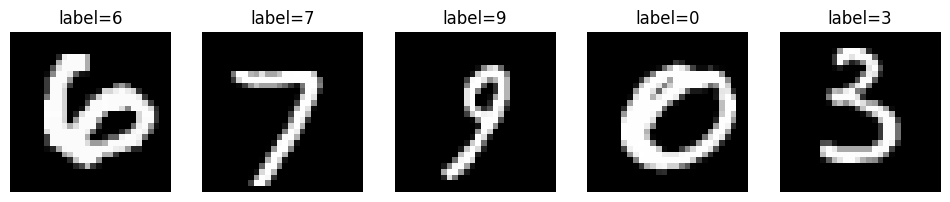

In [6]:
# lets show examples from data 
fig , axis = plt.subplots(1, 5, figsize=(12, 3))

for i , ax in enumerate(axis):
    ax.imshow(x_train[i].squeeze(), cmap='gray')
    ax.set_title(f'label={y_train[i]}')
    ax.axis('off')
plt.show()

#### ✅ Preprocessing functions & data augmentation

In [7]:
batch_size = 128
autotune = tf.data.AUTOTUNE
image_size = (28,28)
num_classes = 10

# Normalization layer 
normalization = layers.Rescaling(1.0/255)

# Simple augmentation pipeline using Keras preprocessing layers
augmentation_layers = keras.Sequential(
    [
        layers.RandomRotation(0.08, seed=seed),
        layers.RandomTranslation(0.06, 0.06, seed=seed),
        layers.RandomZoom(0.06, seed=seed),
    ], name='augmentation')

In [8]:
# Create function to build tf.data.Dataset
def build_data (images , labels,train=False ,batch = batch_size):
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    if train:
        ds = ds.shuffle(10_000, seed=seed)
    ds = ds.map(lambda x, y: (tf.image.resize(x, image_size), y), num_parallel_calls=autotune)
    ds = ds.map(lambda x, y: (normalization(x), y), num_parallel_calls=autotune)
    if train:
        ds = ds.map(lambda x, y: (augmentation_layers(x, training=True), y), num_parallel_calls=autotune)
    ds = ds.batch(batch)
    ds = ds.cache()
    ds = ds.prefetch(autotune)
    return ds

In [9]:
train = build_data(images=x_train , labels=y_train,train=True)
validate = build_data(images=x_validate,labels=y_validate)
test = build_data(images=x_test,labels=y_test)

#### ✅  Model design — Keras Functional API

In [10]:
# We'll implement a compact but powerful convnet with weight decay, BatchNorm, and residual blocks.
def conv_block(x, filters, kernel_size=3, stride=1, weight_decay=1e-4):
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay), use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x


def residual_block(x, filters, weight_decay=1e-4):
    shortcut = x
    x = conv_block(x, filters, 3, 1, weight_decay)
    x = conv_block(x, filters, 3, 1, weight_decay)
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [11]:
def build_model(input_shape=(28, 28, 1), num_classes=num_classes, weight_decay=1e-4, dropout_rate=0.3):
    inputs = keras.Input(shape=input_shape)
    x = conv_block(inputs, 32, kernel_size=3, weight_decay=weight_decay)
    x = conv_block(x, 64, kernel_size=3, weight_decay=weight_decay)
    x = layers.MaxPooling2D(2)(x)

    x = residual_block(x, 64, weight_decay)
    x = layers.MaxPooling2D(2)(x)

    x = conv_block(x, 128, kernel_size=3, weight_decay=weight_decay)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name='mnist_resnet_like')
    return model

In [12]:
model = build_model()
model.summary()

Model: "mnist_resnet_like"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 28, 28, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 28, 28, 32)        │             288 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 28, 28, 32)        │             128 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 28, 28, 32)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 28, 28, 64)        │          18,432 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 28, 28, 64)        │             256 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 28, 28, 64)        │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 14, 14, 64)        │               0 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 14, 14, 64)        │          36,864 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 14, 14, 64)        │             256 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 14, 14, 64)        │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 14, 14, 64)        │          36,864 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 14, 14, 64)        │             256 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 14, 14, 64)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 14, 14, 64)        │               0 │ activation_3[0][0],        │
│                               │                           │               

 Total params: 168,874 (659.66 KB)

 Trainable params: 168,170 (656.91 KB)

 Non-trainable params: 704 (2.75 KB)

#### ✅ Compile: optimizer, loss, metrics, and LR schedule

In [ ]:
# lwt's define cosine decay with restarts learning rate schedule
initial_lr = 1e-3          
epochs = 20
batch_size = 128          
steps_per_epoch = max(1, len(x_train) // batch_size)
first_decay_steps = 10 * steps_per_epoch


# Cosine decay with restarts schedule
cosine_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=float(initial_lr),
    first_decay_steps=first_decay_steps
)

# define the model with the optimizer using the initial learning rate
optimizer = keras.optimizers.Adam(learning_rate=float(initial_lr))


# Compile the model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define a learning rate scheduler callback
def lr_fn_epoch(epoch, current_lr):
    step = epoch * steps_per_epoch
    return float(cosine_schedule(step)) # get learning rate from schedule

lr_scheduler_cb = keras.callbacks.LearningRateScheduler(lr_fn_epoch, verbose=1) 

#### ✅ Callbacks

In [ ]:
# let's define other useful callbacks
# such as early stopping, model checkpointing, and TensorBoard logging
logdir = os.path.join('logs', datetime.now().strftime('%Y%m%d-%H%M%S'))
lr_scheduler_cb = keras.callbacks.LearningRateScheduler(lr_fn_epoch, verbose=1)
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    keras.callbacks.ModelCheckpoint(filepath='best_mnist_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1),
    keras.callbacks.CSVLogger('training_history.csv'),
    lr_scheduler_cb,
]

#### ✅ Train the model

In [ ]:
%%time
history = model.fit( # Train the model
    train,
    validation_data=validate,
    epochs=epochs,
    callbacks=callbacks,
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7825 - loss: 0.8014
Epoch 1: val_loss improved from inf to 8.33097, saving model to best_mnist_model.keras
399/399 ━━━━━━━━━━━━━━━━━━━━ 69s 164ms/step - accuracy: 0.7829 - loss: 0.8004 - val_accuracy: 0.0992 - val_loss: 8.3310 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009755282662808895.
Epoch 2/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9692 - loss: 0.1443
Epoch 2: val_loss improved from 8.33097 to 0.20086, saving model to best_mnist_model.keras
399/399 ━━━━━━━━━━━━━━━━━━━━ 66s 166ms/step - accuracy: 0.9692 - loss: 0.1442 - val_accuracy: 0.9418 - val_loss: 0.2009 - learning_rate: 9.7553e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009045085171237588.
Epoch 3/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9775 - loss: 0.1082
Epoch 3: val_loss did not 

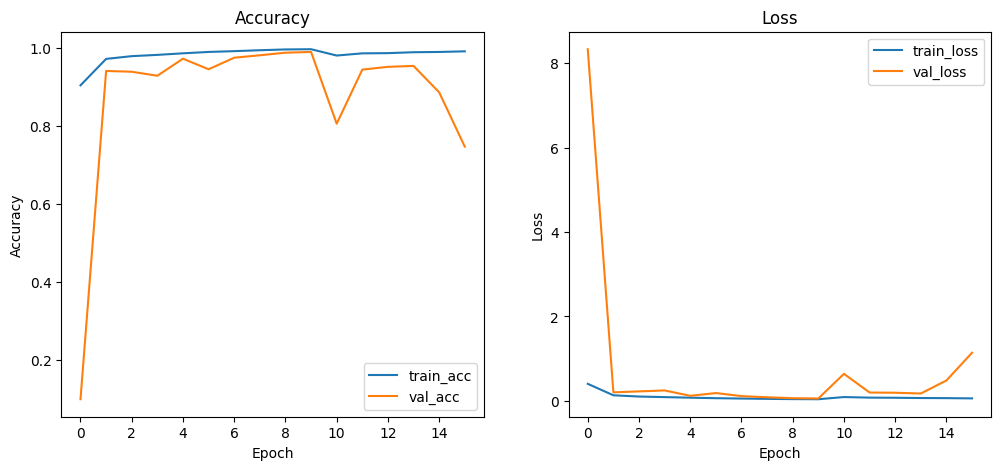

In [ ]:
# now let's plot training history
plt.figure(figsize=(12, 5))
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()

#### ✅ Evaluate on test set and show classification report + confusion matrix

In [ ]:
test_results = model.evaluate(test)
print('Test loss, Test accuracy:', test_results)

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9894 - loss: 0.0614
Test loss, Test accuracy: [0.06022217869758606, 0.9890999794006348]


In [18]:
# Get predictions for confusion matrix
y_pred_probs = model.predict(test)
y_pred = np.argmax(y_pred_probs, axis=1)

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step


In [19]:
# To get the true labels from test_ds (batched), build an array
true_labels = np.concatenate([y for x, y in test], axis=0)

print('\nClassification Report:')
print(classification_report(true_labels, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.99      1.00      1.00      1010
           4       0.98      1.00      0.99       982
           5       1.00      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.97      0.98      1028
           8       0.99      0.99      0.99       974
           9       1.00      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



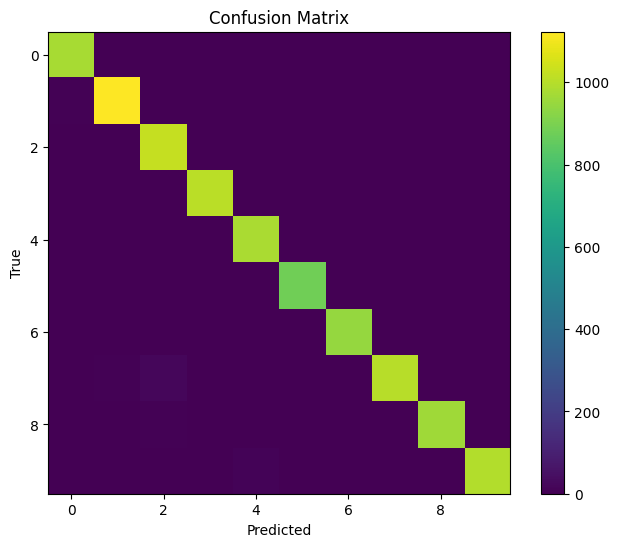

In [20]:
# Confusion matrix
cm = confusion_matrix(true_labels, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### ✅ Hyperparameter tuning with Keras Tuner

In [36]:
# We'll tune: learning rate, dropout_rate, weight_decay, and number of filters in first conv.
def build_model_tuner(hp):
    input_shape = (28, 28, 1)
    num_classes = 10

    # Tunable hyperparameters
    weight_decay = hp.Float("weight_decay", 1e-5, 1e-3, sampling="log")
    dropout_rate = hp.Float("dropout_rate", 0.2, 0.5, step=0.1)
    lr = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")

    inputs = keras.Input(shape=input_shape)


    x = conv_block(inputs, 32, kernel_size=3, weight_decay=weight_decay)
    x = conv_block(x, 64, kernel_size=3, weight_decay=weight_decay)
    x = layers.MaxPooling2D(2)(x)

    x = residual_block(x, 64, weight_decay=weight_decay)
    x = layers.MaxPooling2D(2)(x)

    x = conv_block(x, 128, kernel_size=3, weight_decay=weight_decay)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="mnist_resnet_like_tuned")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=float(lr)),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [46]:
tuner = kt.RandomSearch(  
    build_model_tuner,
    objective="val_accuracy",
    max_trials=25,        
    executions_per_trial=1,
    directory="kt_dir",
    project_name="mnist_resnet_tuning"
)

In [47]:
tuner.search(
    train,
    validation_data=validate,
    epochs=20,  
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True, verbose=1),
        ],
    verbose=1
)

Trial 25 Complete [00h 12m 00s]
val_accuracy: 0.9763333201408386

Best val_accuracy So Far: 0.9856666922569275
Total elapsed time: 04h 41m 51s


In [48]:
best_rn = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Random Search best HPs:", best_rn.values)

#Build the best model with those hyperparameters
best_model_rn = tuner.hypermodel.build(best_rn)

# Define callbacks for final training
rn_check_point = keras.callbacks.ModelCheckpoint(
    "best_rn_model.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

Random Search best HPs: {'weight_decay': 6.729406479006745e-05, 'dropout_rate': 0.4, 'learning_rate': 0.00041350733778281124}


In [49]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True,
    verbose=1
)

In [50]:
# Define local checkpoint path so it doesn't overwrite others
best_history_rn = best_model_rn.fit(
    train,
    validation_data=validate,
    epochs=20,   # or increase if you want longer training
    callbacks=[rn_check_point, early_stop],
    verbose=1
)

Epoch 1/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6649 - loss: 1.1312
Epoch 1: val_loss improved from inf to 8.31261, saving model to best_rn_model.keras
399/399 ━━━━━━━━━━━━━━━━━━━━ 69s 168ms/step - accuracy: 0.6653 - loss: 1.1299 - val_accuracy: 0.0940 - val_loss: 8.3126
Epoch 2/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9585 - loss: 0.2005
Epoch 2: val_loss improved from 8.31261 to 0.26098, saving model to best_rn_model.keras
399/399 ━━━━━━━━━━━━━━━━━━━━ 68s 169ms/step - accuracy: 0.9585 - loss: 0.2005 - val_accuracy: 0.9210 - val_loss: 0.2610
Epoch 3/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9696 - loss: 0.1354
Epoch 3: val_loss improved from 0.26098 to 0.14155, saving model to best_rn_model.keras
399/399 ━━━━━━━━━━━━━━━━━━━━ 67s 168ms/step - accuracy: 0.9696 - loss: 0.1354 - val_accuracy: 0.9644 - val_loss: 0.1415
Epoch 4/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9747 - loss: 0.1101
Epoch 4: val_loss improved f

#### ✅ Evaluate RNbest on test 

In [51]:
rn_test_results = best_model_rn.evaluate(test)
print('Test loss, Test accuracy:', rn_test_results)

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9757 - loss: 0.0934
Test loss, Test accuracy: [0.08943819254636765, 0.9775000214576721]


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       980
           1       1.00      0.97      0.98      1135
           2       0.92      0.99      0.96      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.99       892
           6       0.97      0.99      0.98       958
           7       0.99      0.94      0.97      1028
           8       0.94      1.00      0.97       974
           9       1.00      0.94      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



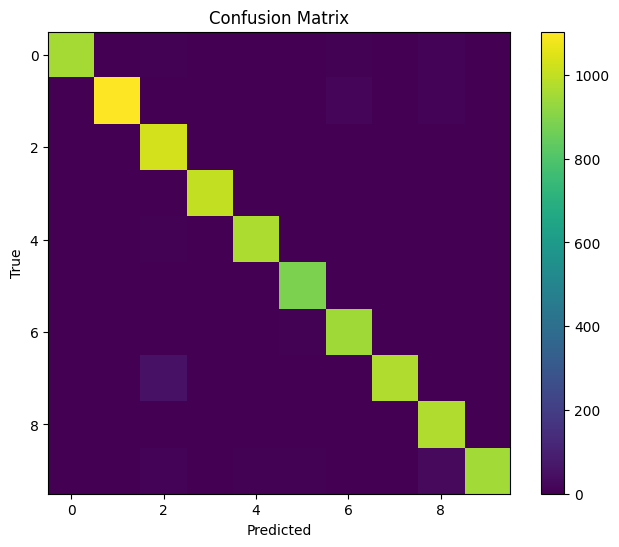

In [53]:
# Get predictions for confusion matrix
rn_y_pred_probs = best_model_rn.predict(test)
rn_y_pred = np.argmax(rn_y_pred_probs, axis=1)

print('\nClassification Report:')
print(classification_report(true_labels, rn_y_pred))

# Confusion matrix
cm = confusion_matrix(true_labels, rn_y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [54]:
best_model_rn.save("final_mnist_tuned_model.keras")

<div style="
    text-align: center;
    background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
    padding: 60px;
    border-radius: 17.5px;
    color: white;
    font-family: Arial, sans-serif;
    box-shadow: 0 10px 30px rgba(0,0,0,0.2);
    margin: 25px auto;
    max-width: 400px;
">
    <div style="font-size: 3rem; margin-bottom: 15px;">Eng.Ahmed Hamed</div>
    <h1 style="margin: 0; font-size: 2rem;">✅</h1>
    <h3 style="margin: 1; font-size: 1.4rem;">Project Done</h1>
    <h4 style="margin: 1; opacity: 0.5; font-size: 1rem">Neural Network Successfully completed!</p>
</div>